# Sentiment Analysis

## Description
Perform sentiment analysis.

## Setup

### Libraries (Pyhton)

In [35]:
import igraph as ig
import json
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
from pathlib import Path
import sys
import copy

### Directories

In [2]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'
RESULTS_MODELS_DIR = RESULTS_DIR / 'models'
RESULTS_MODELS_DIR.mkdir(exist_ok=True)
RESULTS_MODELS_FILE = RESULTS_MODELS_DIR / 'model_results.csv'

### Libraries (Custom)

In [3]:
from importlib import reload

In [4]:
import topic as t

## Import Data

In [27]:
# Graph
filename = RESULTS_GRAPHS_DIR / 'g_dd.graphml'
g_dd_nx = nx.read_graphml(str(filename))
g_dd = ig.Graph.from_networkx(g_dd_nx)

print(g_dd.summary())

IGRAPH UNW- 15819 924974 -- 
+ attr: edge_default (g), node_default (g), _nx_name (v), name (v), weight (e)


In [41]:
# Matrices
filename_pickle_gdd = RESULTS_GRAPHS_DIR / 'g_dd.pickle'
with open(filename_pickle_gdd , 'rb') as f:
    g_dd_matrices = pickle.load(f)

In [11]:
# Original documents
filename_df = DATA_DIR / 'df_dd.json'
df_dd = pd.read_json(str(filename_df), lines=True)
leiden_topics = list(df_dd['leiden_topic'])

In [29]:
# LIWC-22 Results
cols_in = ['document_id', 'leiden_topic', 'emo_pos', 'emo_neg', 'politic', 'health', 'death', 'focuspast', 'focuspresent', 'focusfuture']
filename_liwc_results = RESULTS_MODELS_DIR / 'liwc-22' / 'liwc-22-results.csv'
df = pd.read_csv(filename_liwc_results, usecols=cols_in)

In [20]:
# BERTAgent scores
filename_bertagent_scores = RESULTS_MODELS_DIR / 'bertagent' / 'data' / 'bertagent_scores.json'
with open(filename_bertagent_scores, "r", encoding="utf-8-sig") as f:
    bertagent_scores = json.load(f)
bertagent_scores_int = {int(k): v for k, v in bertagent_scores.items()}

## Preprocess Text for BERTAgent
For efficiency, extract only the first 15 top documents per topic.

In [ ]:
# Get top 15 documents per topic
repr_docs_idx_leiden = t.get_louvain_community_reps(g_dd, leiden_topics, top_k=15)
doc_id_to_text = dict(zip(df_dd['document_id'], df_dd['og_text']))

# Build the new dictionary
repr_docs_text_leiden = {
    topic: [doc_id_to_text[doc_id] for doc_id in doc_ids if doc_id in doc_id_to_text]
    for topic, doc_ids in repr_docs_idx_leiden.items()
}

In [17]:
# Flatten the dictionary into a list of dicts, removing outlier topics
rows = [
    {"leiden_topic": topic, "text": text}
    for topic, texts in repr_docs_text_leiden.items() if topic<=12
    for text in texts
]

# Create the DataFrame
df_repr_docs = pd.DataFrame(rows)

In [18]:
# Save to .csv
filename_repr_docs = RESULTS_MODELS_DIR / 'bertagent' / 'data' / 'repr_docs.csv'
df_repr_docs['text'] = df_repr_docs['text'].astype(str)
df_repr_docs.to_csv(filename_repr_docs, index=False, encoding='utf-8-sig')

## LIWC-22 Analysis

In [33]:
df.head()

,document_id,leiden_topic,emo_pos,emo_neg,politic,health,death,focuspast,focuspresent,focusfuture,tot_emo_pos,bertagent_score
0,1h7okhk,1,0.00,0.58,0.0,0.00,0.00,10.98,5.20,0.00,-0.58,0.038739
1,1ht5ang,1,0.23,0.82,0.0,1.17,0.00,9.47,3.39,0.47,-0.59,0.038739
2,1haqyqt,1,1.35,1.35,0.0,0.00,0.00,13.51,2.70,0.00,0.00,0.038739
3,1hong9g,1,1.01,1.01,0.0,0.00,0.00,5.53,5.53,1.51,0.00,0.038739
4,1hhl0q7,1,1.30,1.51,0.0,0.43,0.22,9.07,5.62,1.51,-0.21,0.038739


In [ ]:
# Calculate composite "positive emotion" score
df["tot_emo_pos"] = df["emo_pos"] - df["emo_neg"]

# Map BERTAgent scores to topic
df['bertagent_score'] = df['leiden_topic'].map(bertagent_scores_int)

In [36]:
# Assign attributes from LIWC-22 and BERTAgent to nodes
attributes_to_assign = [
    'leiden_topic', 'tot_emo_pos', 'health', 'death',
    'politic', 'focuspast', 'focuspresent', 'focusfuture', 'bertagent_score'
]

# Create a lookup dictionary from the DataFrame
df_copy = copy.deepcopy(df)
df_copy.set_index('document_id', inplace=True)
attr_dict = df_copy[attributes_to_assign].to_dict(orient='index')

# Iterate over nodes and assign attributes
for v in g_dd.vs:
    doc_id = v['name']
    if doc_id in attr_dict:
        for attr, value in attr_dict[doc_id].items():
            v[attr] = value
    else:
        print(f"Warning: document_id {doc_id} not found in DataFrame.")

In [40]:
# Save to graphml
filename_graph = RESULTS_GRAPHS_DIR / 'sentiment_graph.graphml'
g_dd.write_graphml(str(filename_graph))

### Build Topic Graph

In [82]:
# List of metrics to aggregate
metrics = [
    'politic', 'health', 'death',
    'focuspast', 'focuspresent', 'focusfuture',
    'tot_emo_pos', 'bertagent_score'
]

# Group by topic and compute medians
topic_df = df.groupby('leiden_topic')[metrics].mean().reset_index()

In [83]:
# Extract C
topics = list(df['leiden_topic'])
num_docs, num_topics, C = t.extract_community_assignments(topics, topic_ids_start=1)

In [57]:
# Normalize existing matrices
Pwd = g_dd_matrices['Pwd'] / g_dd_matrices['Pwd'].sum()
Pdd = g_dd_matrices['Pdd'] / g_dd_matrices['Pdd'].sum()

In [84]:
# Update topic matrices
Pwc = Pwd.dot(C)              # Joint word + class probability
Pcc = ((C.T).dot(Pdd)).dot(C) # Joint class + class probability
pc = Pcc.sum(axis=0) # Topic co-occurrence weights (node strength of each topic in the topic co-occurrence matrix)

In [86]:
# Number of topics
n_topics = Pcc.shape[0]

# Create a graph with n_topics nodes
g_topic = ig.Graph()
g_topic.add_vertices(n_topics)

# Add node attribute: topic ID
g_topic.vs['leiden_topic'] = list(range(n_topics))

# Set median attributes on each topic node
for attr in metrics:
    # Map from leiden_topic -> value
    values = topic_df.set_index('leiden_topic')[attr]
    g_topic.vs[attr] = [values.get(t, None) for t in g_topic.vs['leiden_topic']]

# Build edges from upper triangle of the Pcc matrix (symmetric)
edges = []
weights = []

for i in range(n_topics):
    for j in range(i+1, n_topics):
        weight = Pcc[i, j]
        if weight > 0:  # Only keep non-zero edges
            edges.append((i, j))
            weights.append(weight)

# Add edges and their weights
g_topic.add_edges(edges)
g_topic.es['weight'] = weights

In [75]:
import matplotlib.pyplot as plt

layout = g_topic.layout("fr")  # Fruchterman-Reingold layout

# Optional: scale node sizes by a metric (e.g., bertagent_score)
sizes = g_topic.vs["bertagent_score"]
max_size = max(sizes) if sizes else 1
sizes = [20 + 80 * (s / max_size) if s is not None else 20 for s in sizes]

# Optional: set labels
labels = g_topic.vs["leiden_topic"]

# Plot
ig.plot(
    g_topic,
    layout=layout,
    vertex_size=sizes,
    vertex_label=labels,
    vertex_color="lightblue",
    edge_width=[w / max(g_topic.es["weight"]) * 3 for w in g_topic.es["weight"]],
    bbox=(800, 800),
    margin=50
)

AttributeError: Plotting not available; please install pycairo or cairocffi

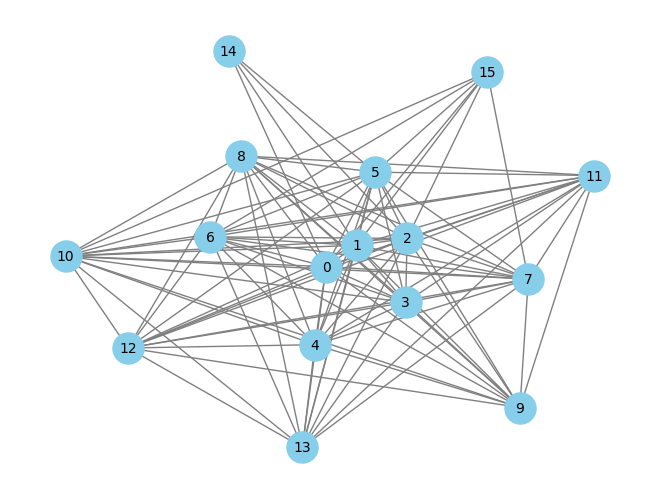

In [87]:
import networkx as nx

# Convert igraph to networkx
nx_graph = g_topic.to_networkx()

# Draw using networkx
pos = nx.spring_layout(nx_graph)
node_labels = {i: d['leiden_topic'] for i, d in nx_graph.nodes(data=True)}

nx.draw(
    nx_graph, pos,
    with_labels=True,
    labels=node_labels,
    node_size=500,
    node_color='skyblue',
    edge_color='gray',
    font_size=10
)

plt.show()

In [90]:
# Save to graphml
filename_topic_graph = RESULTS_GRAPHS_DIR / 'topics_graph.graphml'
g_topic.write_graphml(str(filename_topic_graph))

In [81]:
print(g_topic.vs[0])

igraph.Vertex(<igraph.Graph object at 0x000002767A03AF50>, 0, {'leiden_topic': 0, 'politic': np.float64(2.727296116504854), 'health': np.float64(0.46537378640776694), 'death': np.float64(0.2786844660194175), 'focuspast': np.float64(3.070611650485437), 'focuspresent': np.float64(6.781771844660194), 'focusfuture': np.float64(1.7669951456310677), 'tot_emo_pos': np.float64(-0.2803252427184466), 'bertagent_score': np.float64(0.03826851965433928)})


## Clear Allocated Memory

In [ ]:
# Run before exiting the program to clear memory
%reset -f
import gc
gc.collect()